##데이터 준비 
multi30k 데이터와 토크나이져로 spacy를 이용하였으며
데이터 준비 코드는 그대로 참고하였습니다.

In [ ]:
!pip install torchtext==0.6.0

In [ ]:
%%capture
!python -m spacy download en
!python -m spacy download de

In [ ]:
import spacy

spacy_en = spacy.load('en') # 영어 토큰화(tokenization)
spacy_de = spacy.load('de') # 독일어 토큰화(tokenization)

In [ ]:
tokenized = spacy_en.tokenizer("I am a graduate student.")

for i, token in enumerate(tokenized):
    print(f"인덱스 {i}: {token.text}")

인덱스 0: I
인덱스 1: am
인덱스 2: a
인덱스 3: graduate
인덱스 4: student
인덱스 5: .


In [ ]:
# 독일어(Deutsch) 문장을 토큰화 하는 함수 (순서를 뒤집지 않음)
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

# 영어(English) 문장을 토큰화 하는 함수
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

In [ ]:
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

In [ ]:
from torchtext.datasets import Multi30k

train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts=(".de", ".en"), fields=(SRC, TRG))

In [ ]:
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset.examples)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_dataset.examples)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_dataset.examples)}개")

학습 데이터셋(training dataset) 크기: 29000개
평가 데이터셋(validation dataset) 크기: 1014개
테스트 데이터셋(testing dataset) 크기: 1000개


In [ ]:
# 학습 데이터 중 하나를 선택해 출력
print(vars(train_dataset.examples[29])['src'])
print(vars(train_dataset.examples[29])['trg'])

['ein', 'junger', 'mann', 'in', 'einer', 'schwarz-gelben', 'jacke', 'blickt', 'etwas', 'an', 'und', 'lächelt', '.']
['a', 'young', 'man', 'in', 'a', 'black', 'and', 'yellow', 'jacket', 'is', 'gazing', 'at', 'something', 'and', 'smiling', '.']


In [ ]:
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 7855
len(TRG): 5893


In [ ]:
import torch

device = torch.device('cpu')

BATCH_SIZE = 128

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device)

In [ ]:
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([128, 28])
인덱스 0: 2
인덱스 1: 18
인덱스 2: 30
인덱스 3: 879
인덱스 4: 5
인덱스 5: 0
인덱스 6: 27
인덱스 7: 14
인덱스 8: 2309
인덱스 9: 4
인덱스 10: 3
인덱스 11: 1
인덱스 12: 1
인덱스 13: 1
인덱스 14: 1
인덱스 15: 1
인덱스 16: 1
인덱스 17: 1
인덱스 18: 1
인덱스 19: 1
인덱스 20: 1
인덱스 21: 1
인덱스 22: 1
인덱스 23: 1
인덱스 24: 1
인덱스 25: 1
인덱스 26: 1
인덱스 27: 1


##멀티해드 어텐션 구현 

In [ ]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
  
  def __init__(self, hidden_dim, n_heads, device):
    super().__init__()

    self.hidden_dim = hidden_dim 
    self.n_heads = n_heads 
    self.head_dim = hidden_dim // n_heads

    self.fc_q = nn.Linear(hidden_dim, hidden_dim) 
    self.fc_k = nn.Linear(hidden_dim, hidden_dim) 
    self.fc_v = nn.Linear(hidden_dim, hidden_dim) 

    self.fc_o = nn.Linear(hidden_dim, hidden_dim)
    #concat이후 마지막으로 거쳐가는 linear입니다.
    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
    #attention을 구하는 과정에서 Q K를 곱한 값이 너무 커지는 것을 막기위해서 적당한 값을 나눠줌 여기서는 루트 head_dim 입니다.

  def forward(self, query, key, value, mask = None):

    batch_size = query.shape[0] 
    #query key value의 배치 사이즈를 확인하기 위해서 shape의 첫번째 값 확인합니다.

    # query: [batch_size, query_len, hidden_dim]
    # key: [batch_size, key_len, hidden_dim]
    # value: [batch_size, value_len, hidden_dim]

    Q = self.fc_q(query)
    K = self.fc_k(key)
    V = self.fc_v(value)

    # fc의 W가 hidden_dim * hidden_dim이기때문에 형태가 그대로 나옵니다.

    # Q: [batch_size, query_len, hidden_dim]
    # K: [batch_size, key_len, hidden_dim]
    # V: [batch_size, value_len, hidden_dim]

    # hidden_dim → n_heads X head_dim 형태로 변형
    # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도

    # view를 통해서 [batch_size, ??? , n_heads, head_dim]의 shape로 변환 ???는 자연스럽게 query_len이 됨
    # permute를 통해서 n_heads와 query_len 위치를 바꿔줌
    Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

    # Q: [batch_size, n_heads, query_len, head_dim]
    # K: [batch_size, n_heads, key_len, head_dim]
    # V: [batch_size, n_heads, value_len, head_dim]

    # Attention Energy 계산 Q, K 전치한 것을 계산
    energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

    # energy: [batch_size, n_heads, query_len, key_len] 
    # 마스크(mask)를 사용하는 경우
    if mask is not None:
        # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
        # 마이너스 무한의 값을 넣어주면서 의미없는 값으로 바꾸는 과정

        energy = energy.masked_fill(mask==0, -1e10)

    # 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값
    attention = torch.softmax(energy, dim=-1)

    # attention: [batch_size, n_heads, query_len, key_len]

    # 여기에서 Scaled Dot-Product Attention을 계산
    x = torch.matmul(attention, V)

    # x: [batch_size, n_heads, query_len, head_dim]

    # 아래는 head개수에 따라서 나눴던 matrix를 다시 합쳐주는 과정입니다.

    x = x.permute(0, 2, 1, 3).contiguous()

    # x: [batch_size, query_len, n_heads, head_dim]

    x = x.view(batch_size, -1, self.hidden_dim)

    # x: [batch_size, query_len, hidden_dim]

    x = self.fc_o(x)

    # x: [batch_size, query_len, hidden_dim]

    return x, attention


### 멀티헤드 어텐션 이후 residual learning을 위한 add 및 normalization을 마치면 feedforwardLayer를 통해서 한번 정재해주는 과정을 가집니다.

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = torch.relu(self.fc_1(x))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x


## 셀프 어텐션을 진행할 EncoderLayer를 생성


In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim)
        

    # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention)할 단어를 조절 가능
        _src, _ = self.self_attention(src, src, src, src_mask)

        # residual connection and layer norm
        # 셀프 어텐션을 진행한 _src에 원래 src를 더하여 residual learning 진행
        src = self.self_attn_layer_norm(src + _src)

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # residual and layer norm
        src = self.ff_layer_norm(src + _src)

        # src: [batch_size, src_len, hidden_dim]

        return src

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, device, max_length=100):
        super().__init__()

        self.n_heads = n_heads
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.pf_dim = pf_dim

        self.device = device

        #각 단어를 hidden_dim 만큼 embedding 합니다. 
        self.tok_embedding = nn.Embedding(input_dim, hidden_dim) 
        #max_length의 길이로 들어온 데이터의 위치 데이터를 positional encoding으로 나타냄
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)
        
        #n개 만큼 EncoderLayer 생성
        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, device) for _ in range(n_layers)])

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)


    #학습을 위한 layer 추가 함수
    def append_layer(self):
      self.layers.append(EncoderLayer(self.hidden_dim, self.n_heads, self.pf_dim, self.device))
      self.n_layers += 1

      
    # 기존과 다르게 각 레이어의 output을 리스트의 형태로 모두 리턴합니다.
    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
        src =(self.tok_embedding(src) * self.scale) + self.pos_embedding(pos)

        # src: [batch_size, src_len, hidden_dim]

        ret_src = [src]

        # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for layer in self.layers:
            ret_src.append(layer(ret_src[-1], src_mask))

        # src: [batch_size, src_len, hidden_dim]

        return ret_src # 마지막 레이어의 출력을 반환

    

## 디코더 레이어
셀프 어텐션 - 인코더 디코더 어텐션 - feedforward
의 순서로 진행

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim)
        

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [n_layers, batch_size, src_len, hidden_dim] <= 인코더를 거쳐간 결과 각 레이어 층에서의 결과 모두 사용
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # 자기 자신에 대하여 어텐션(attention)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + _trg)

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + _trg)

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # residual and layer norm
        trg = self.ff_layer_norm(trg + _trg)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

## 디코더 
인코더와 비슷한 형태이지만 layer에 attention이 2개가 존재하며 하나는 encoder에서 추출한 데이터를 K, V로 사용합니다.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim,  device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)


        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = (self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos)

        # trg: [batch_size, trg_len, hidden_dim]
        i = 0
        
        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            # 병렬적으로 레이어를 사용 하지만 인코더보다 레이어가 많아 질 경우 마지막 인코더 레이어에서의 src를 사용
            trg, attention = layer(trg, enc_src[i], trg_mask, src_mask)
            if i < len(enc_src) - 1:
              i += 1
            

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

##Transformer
마스크를 마지막으로 구현하고 인코더와 디코더를 이용하여 
output과 attention을 구합니다.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    
    #트렌스포머 내의 인코더에 레이어를 추가하는 함수
    def append_encoderlayer(self):
      self.encoder.append_layer()


    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [n_layers,batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

##학습시키기 


In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 32
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 64
DEC_PF_DIM = 64


In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

파라미터 개수 확인

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 704,933 trainable parameters


weight 초기화

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 32)
    (pos_embedding): Embedding(100, 32)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=32, out_features=32, bias=True)
          (fc_k): Linear(in_features=32, out_features=32, bias=True)
          (fc_v): Linear(in_features=32, out_features=32, bias=True)
          (fc_o): Linear(in_features=32, out_features=32, bias=True)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=32, out_features=64, bias=True)
          (fc_2): Linear(in_features=64, out_features=32, bias=True)
        )
      )
      (1): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
 

옵티마이져로 Adam을 사용합니다.

In [ ]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 출력 단어의 마지막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 1m 48s
	Train Loss: 6.616 | Train PPL: 747.217
	Validation Loss: 5.265 | Validation PPL: 193.447
Epoch: 02 | Time: 1m 44s
	Train Loss: 4.758 | Train PPL: 116.568
	Validation Loss: 4.126 | Validation PPL: 61.927
Epoch: 03 | Time: 1m 43s
	Train Loss: 3.860 | Train PPL: 47.473
	Validation Loss: 3.488 | Validation PPL: 32.731
Epoch: 04 | Time: 1m 44s
	Train Loss: 3.349 | Train PPL: 28.466
	Validation Loss: 3.126 | Validation PPL: 22.788
Epoch: 05 | Time: 1m 44s
	Train Loss: 3.017 | Train PPL: 20.425
	Validation Loss: 2.903 | Validation PPL: 18.227
Epoch: 06 | Time: 1m 48s
	Train Loss: 2.767 | Train PPL: 15.918
	Validation Loss: 2.739 | Validation PPL: 15.464
Epoch: 07 | Time: 1m 46s
	Train Loss: 2.568 | Train PPL: 13.043
	Validation Loss: 2.619 | Validation PPL: 13.716
Epoch: 08 | Time: 1m 47s
	Train Loss: 2.410 | Train PPL: 11.131
	Validation Loss: 2.537 | Validation PPL: 12.637
Epoch: 09 | Time: 1m 45s
	Train Loss: 2.275 | Train PPL: 9.728
	Validation Loss: 2.472 | Vali

In [ ]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [ ]:
example_idx = 30

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['sechs', 'leute', 'fahren', 'mountainbikes', 'durch', 'eine', 'dschungellandschaft', '.']
타겟 문장: ['six', 'people', 'ride', 'mountain', 'bikes', 'through', 'a', 'jungle', 'environment', '.']
전체 소스 토큰: ['<sos>', 'sechs', 'leute', 'fahren', 'mountainbikes', 'durch', 'eine', 'dschungellandschaft', '.', '<eos>']
소스 문장 인덱스: [2, 413, 73, 137, 4891, 58, 8, 0, 4, 3]
모델 출력 결과: six people are riding through people riding through people . <eos>


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=4, n_rows=4, n_cols=2):

   

    # 출력할 그림 크기 조절
    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # 어텐션(Attention) 스코어 확률 값을 이용해 그리기
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

소스 문장: ['sechs', 'leute', 'fahren', 'mountainbikes', 'durch', 'eine', 'dschungellandschaft', '.']
타겟 문장: ['six', 'people', 'ride', 'mountain', 'bikes', 'through', 'a', 'jungle', 'environment', '.']
전체 소스 토큰: ['<sos>', 'sechs', 'leute', 'fahren', 'mountainbikes', 'durch', 'eine', 'dschungellandschaft', '.', '<eos>']
소스 문장 인덱스: [2, 413, 73, 137, 4891, 58, 8, 0, 4, 3]
모델 출력 결과: six people are riding through people riding through people . <eos>


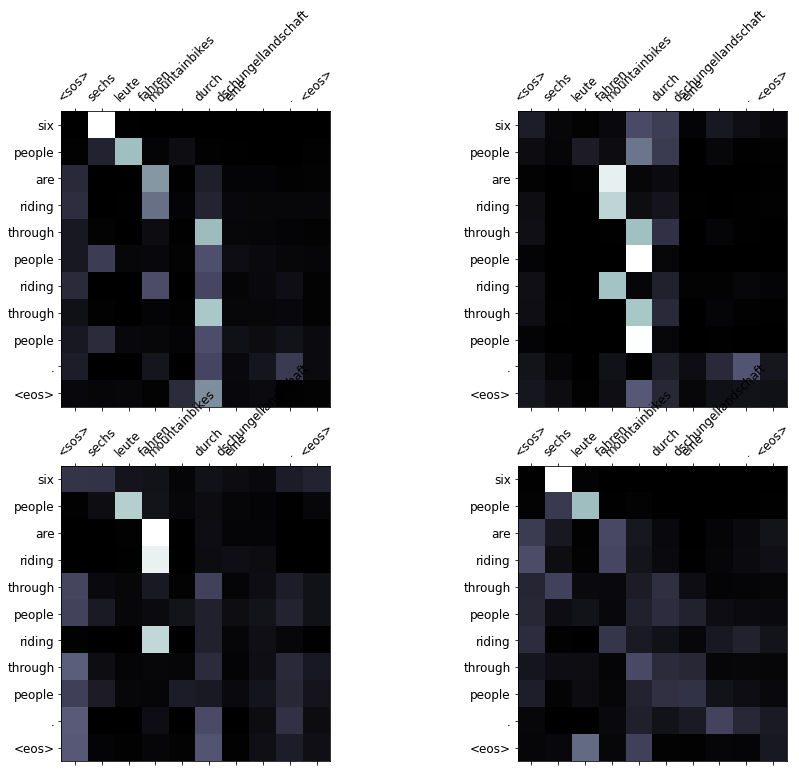

In [35]:
example_idx = 30

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

display_attention(src, translation, attention)

In [ ]:
from torchtext.data.metrics import bleu_score

def show_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

        # 마지막 <eos> 토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}') 
    print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}') 
    print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}') 
    print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}') 

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}') 
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}') 
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}') 
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}') 

In [ ]:
show_bleu(test_dataset, SRC, TRG, model, device)

[100/1000]
예측: ['a', 'group', 'of', 'asian', 'children', 'sitting', 'around', 'sitting', 'around', 'outside', 'of', 'blue', 'chairs', '.']
정답: ['a', 'group', 'of', 'mostly', 'asian', 'children', 'sitting', 'at', 'cubicles', 'in', 'blue', 'chairs', '.']
[200/1000]
예측: ['people', 'in', 'a', 'group', 'of', 'people', 'standing', 'under', 'their', 'hands', '.']
정답: ['the', 'group', 'of', 'people', 'are', 'all', 'covered', 'by', 'umbrellas', '.']
[300/1000]
예측: ['a', 'man', 'in', 'a', 'yellow', 'uniform', 'is', 'trying', 'to', 'be', 'the', 'ball', '.']
정답: ['a', 'goalie', 'in', 'a', 'yellow', 'field', 'is', 'protecting', 'the', 'goal', '.']
[400/1000]
예측: ['two', 'young', 'children', 'on', 'the', 'sand', '.']
정답: ['two', 'young', 'children', 'are', 'on', 'sand', '.']
[500/1000]
예측: ['two', 'blond', 'dogs', 'running', 'through', 'the', 'snow', '.']
정답: ['two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.']
[600/1000]
예측: ['a', 'group', 'of', 'men', 'sitting', 'while', 'sittin